In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict, deque
import time
import os
import json

In [2]:
# Example of a DAG with 10 tasks for simplicity
# tasks = [f'T{i}' for i in range(1, 11)]
# edges = [('T1', 'T2'), ('T1', 'T3'), ('T2', 'T4'), ('T3', 'T4'), ('T4', 'T5'), ('T5', 'T6'), ('T6', 'T7'), ('T6', 'T8'), ('T7', 'T9'), ('T8', 'T10')]
# delays = {f'T{i}': random.randint(1, 5) for i in range(1, 11)}
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 2, 'B': 1, 'C': 2, 'D': 1, 'E': 0}

In [3]:
def is_valid_schedule(schedule):
    """Check if the schedule respects the precedence constraints."""
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [22]:
def calculate_finish_time(schedule, edges, delays):
    """Calculate the finish time of a given schedule."""
    graph = defaultdict(list)
    finish_times = {t: delays[t] for t in tasks}
    
    for u, v in edges:
        graph[u].append(v)

    for i in range(1, len(schedule)):
        finish_times[schedule[i]] += finish_times[schedule[i-1]] + 1
    
    finish_time = max(finish_times.values())
    
    return finish_times, finish_time

In [12]:
def create_initial_population(size):
    """Create an initial population of valid schedules."""
    population = []
    for _ in range(size):
        while True:
            schedule = random.sample(tasks, len(tasks))
            if is_valid_schedule(schedule):
                population.append(schedule)
                break
    return population

In [23]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return min(chosen, key=lambda x: calculate_finish_time(x, edges, delays)[1])

In [14]:
def crossover(parent1, parent2):
    """Perform crossover between two parents to create a child."""
    idx1, idx2 = sorted(random.sample(range(len(tasks)), 2))
    child = [None] * len(tasks)
    child[idx1:idx2+1] = parent1[idx1:idx2+1]
    
    current_pos = 0
    for task in parent2:
        if task not in child:
            while child[current_pos] is not None:
                current_pos += 1
            child[current_pos] = task
    return child

In [15]:
def mutate(schedule):
    """Perform mutation by swapping two random tasks."""
    idx1, idx2 = random.sample(range(len(tasks)), 2)
    schedule[idx1], schedule[idx2] = schedule[idx2], schedule[idx1]
    return schedule

In [29]:
def genetic_algorithm(population_size, num_generations, tournament_size, elitism_size, mutation_prob):
    population = create_initial_population(population_size)
    new_population = population.copy()
    start_time = time.time()
    for i in range(num_generations):
        population = sorted(population, key=lambda s: calculate_finish_time(s, edges, delays)[1])
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)

            child = crossover(parent1, parent2)
            
            if random.random() < mutation_prob:
                child = mutate(child)
            if is_valid_schedule(child):
                new_population.append(child)
        
        population = new_population.copy()
    end_time = time.time()
    time_taken = end_time - start_time
    best_schedule = min(population, key=lambda s: calculate_finish_time(s, edges, delays)[1])
    finish_times, finish_time = calculate_finish_time(best_schedule, edges, delays)
    return best_schedule, finish_times, finish_time, time_taken

In [30]:
# Run the genetic algorithm
best_schedule, finish_times, best_finish_time, time_taken = genetic_algorithm(population_size=100, 
                                                    num_generations=50, 
                                                    tournament_size=7,
                                                    elitism_size=3,
                                                    mutation_prob=0.1)

print("The order of the task completion:", best_schedule)
print("Earliest completion times for each task:", finish_times)
print("Minimum finish time:", best_finish_time)
print("Time taken to find a solution:", time_taken)

The order of the task completion: ['A', 'B', 'C', 'D', 'E']
Earliest completion times for each task: {'A': 2, 'B': 4, 'C': 7, 'D': 9, 'E': 10}
Minimum finish time: 10
Time taken to find a solution: 0.20644807815551758


In [18]:
def draw_graph(tasks, edges, delays):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    
    # Add edges with weights (delays)
    G.add_edges_from(edges)
    
    # Define positions for nodes using a layout
    pos = nx.spring_layout(G)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=20)
    
    # Draw the delays as separate text next to the nodes
    for node, (x, y) in pos.items():
        plt.text(x + 0.09, y - 0.075, s=f"Delay: {delays[node]}", bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center', fontsize=12, color='blue')
    
    # Show the plot
    plt.show()

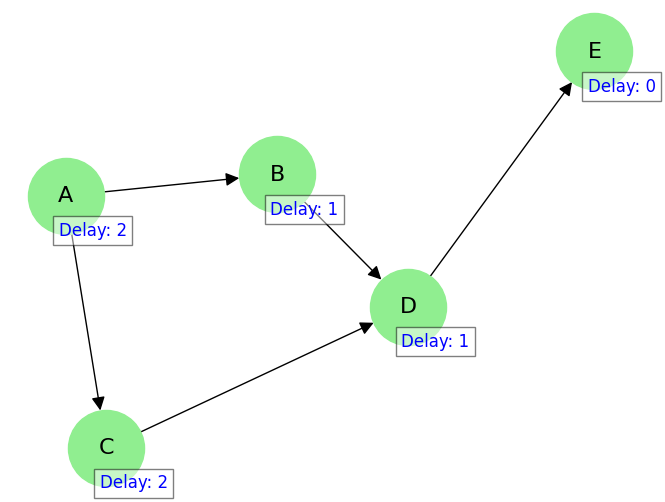

In [19]:
draw_graph(tasks, edges, delays)

In [36]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

The order of the task completion: ['D', 'A', 'B', 'E', 'C']
Earliest completion times for each task: {'A': 5, 'B': 8, 'C': 14, 'D': 2, 'E': 10}
Minimum finish time: 14
Time taken to find a solution: 0.1815338134765625


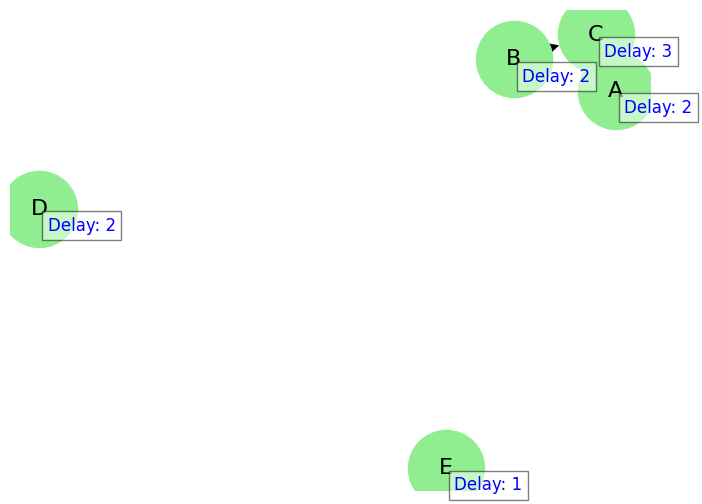

----------------------------------------------
The order of the task completion: ['D', 'A', 'B', 'C', 'E', 'F']
Earliest completion times for each task: {'A': 3, 'B': 8, 'C': 9, 'D': 2, 'E': 10, 'F': 14}
Minimum finish time: 14
Time taken to find a solution: 0.25834107398986816


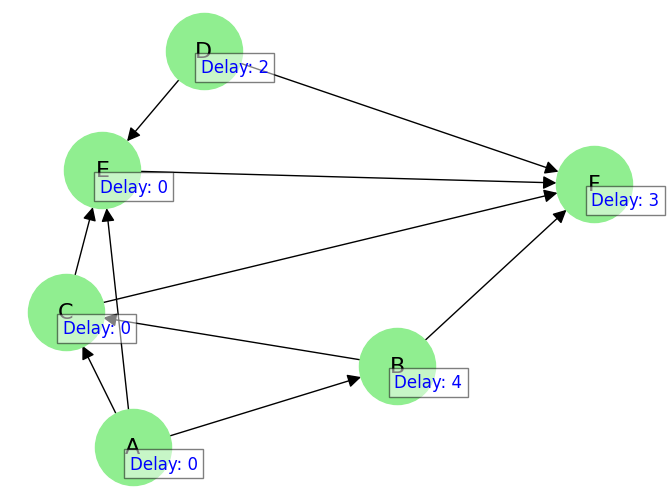

----------------------------------------------
The order of the task completion: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
Earliest completion times for each task: {'A': 2, 'B': 5, 'C': 7, 'D': 11, 'E': 15, 'F': 19, 'G': 22}
Minimum finish time: 22
Time taken to find a solution: 0.2842123508453369


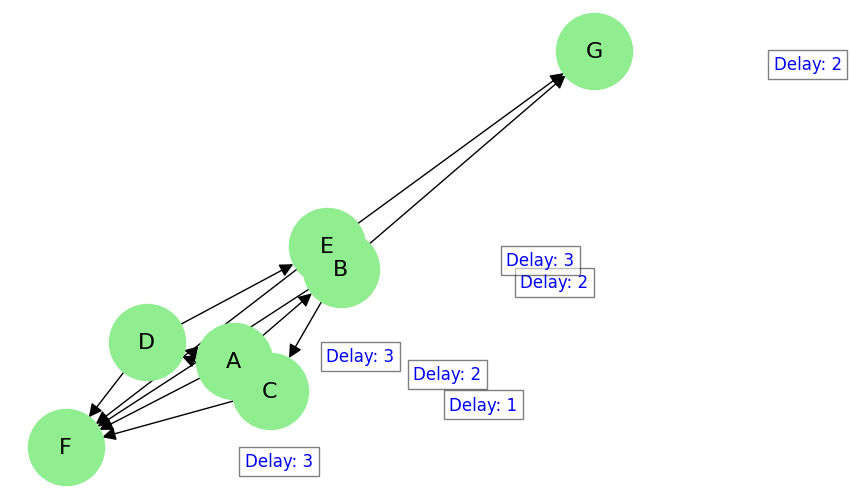

----------------------------------------------
The order of the task completion: ['A', 'C', 'B', 'D', 'E', 'F', 'H', 'G']
Earliest completion times for each task: {'A': 3, 'B': 10, 'C': 5, 'D': 12, 'E': 16, 'F': 22, 'G': 26, 'H': 24}
Minimum finish time: 26
Time taken to find a solution: 0.31116771697998047


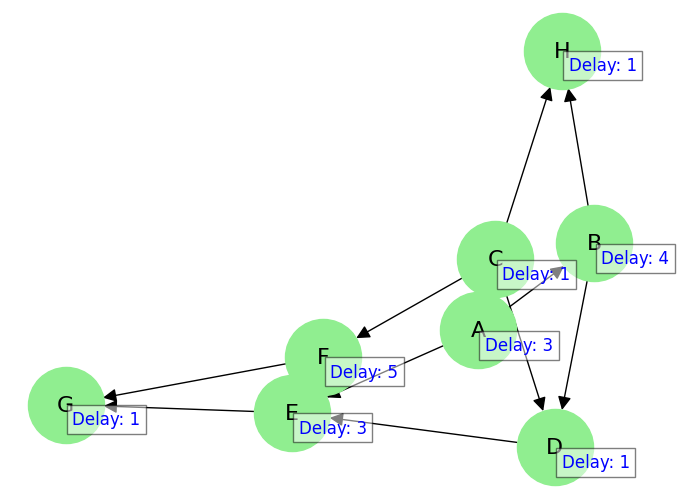

----------------------------------------------
The order of the task completion: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
Earliest completion times for each task: {'A': 1, 'B': 5, 'C': 10, 'D': 12, 'E': 17, 'F': 18, 'G': 24, 'H': 26, 'I': 31}
Minimum finish time: 31
Time taken to find a solution: 0.37699222564697266


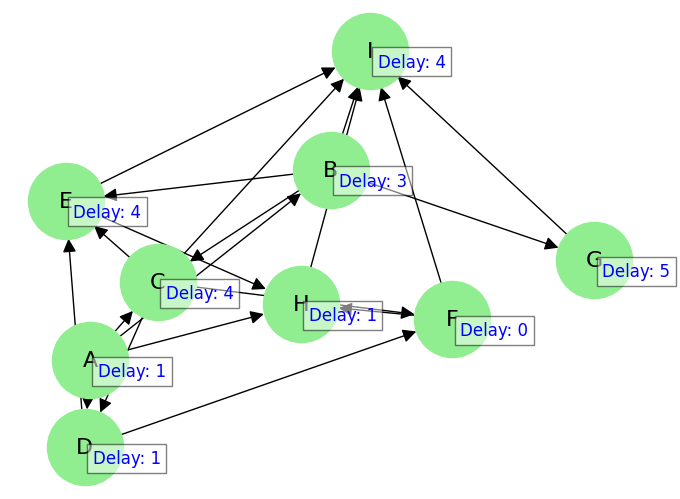

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/GA.json' mode='w' encoding='cp1252'>


In [37]:
path = 'test_files/'
files = os.listdir(path)
# Filter files that match the pattern 'test_file_*.py'
data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
data_to_write = []
# Loop through each file and import the data
for file_name in data_files:
    file_path = os.path.join(path, file_name)
    with open(file_path, 'r') as f:
        loaded_data = json.load(f)
        tasks = loaded_data.get('tasks')
        edges = loaded_data.get('edges')
        delays = loaded_data.get('delays')

        # finish_times, finish_time, order_of_tasks, time_taken = mpcs(tasks, edges, delays)
        best_schedule, finish_times, best_finish_time, time_taken = genetic_algorithm(population_size=100, 
                                                    num_generations=50, 
                                                    tournament_size=7,
                                                    elitism_size=3,
                                                    mutation_prob=0.1)
        print("The order of the task completion:", best_schedule)
        print("Earliest completion times for each task:", finish_times)
        print("Minimum finish time:", best_finish_time)
        print("Time taken to find a solution:", time_taken)
        draw_graph(tasks, edges, delays)
        print("----------------------------------------------")
        data = {
        'test_name' : file_name,
        'order_of_tasks': best_schedule,
        'finish_times': finish_times,
        'finish_time': best_finish_time,
        'time_taken': time_taken
        }
        data_to_write.append(data)

result_file = 'results/GA.json'
save_results(result_file, data_to_write)

In [20]:
# import random

# edges = []
# for i in range(1, 30001):
#     # Define the range of nodes that can be connected to
#     start = i + 1
#     end = min(i + 5, 30001)  # Ensure we do not go out of bounds
#     # Compute the maximum number of targets we can sample
#     max_targets = end - start
#     if max_targets > 0:
#         num_connections = random.randint(1, min(5, max_targets))  # Random number of connections within the bounds
#         targets = random.sample(range(start, end), num_connections)
#         for target in targets:
#             edges.append((f'T{i}', f'T{target}'))

In [21]:
# import random

# delays = {f'T{i}': random.randint(1, 10) for i in range(1, 30001)}